In [5]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

## Задача Сода

Бесконечная труба заполнена воздухом (показатель адиабаты $\gamma = 1.4$), в точке $x = 0$ разделена перегородкой. При $t = 0$ слева от перегородки $(\rho, u, p)^T = (1, 0, 1)$, справа - $(\rho, u, p)^T = (0.125, 0, 0.1)$, где $\rho$ - плотность газа, $u$ - его скорость, $p$ - давление. Найти решение в момент времени $t\approx 0.504$. Считать воздух идеальным газом.

Уравнения газовой динамики и численный метод выписаны в книге [1], c.112-117. Там же приводятся графики решения, с которыми надо сверять свое решение.
1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

### Задание

Часть 1:
1. Реализовать все недостающие функции
2. Получить решение с постоянным шагом $\tau = 0.001$
3. Получить решение c $\tau_k = r\tau_{max}$, $\tau_{max}$ зависит от решения на текущем шаге. Постройте график зависимости $\tau_k$ от номера шага.
4. Прокомментировать решение, полученное в двух предыдущих пунктах
5. Укажите положение ударной волны и контактного разрыва
6. Прокомментируйте допустимость предложенного в коде варианта задания граничных условий. Стоит ли его заменить?

Часть 2: 
1. Реализуйте схему с искусственной вязкостью и проведите расчет в согласии с пунктом 3.
2. Прокомментируйте решение.

### Схема Лакса-Вендроффа для решения задачи Сода

Примитивные переменные $(\rho, u, p)^T$, консервативные - $(\rho, \rho u, \rho(e + u^2/2))$.

In [6]:
nx = 101  # количество узлов по пространству
h = 2 / (nx-1) # шаг по пространству
x_mesh = np.linspace(-1, 1, nx) #сетка по пространству
gamma = 1.4 # показатель адиабаты

In [3]:
# Пересчет прититивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5*u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho*ekin])

# Пересчет консервативныx переменных в примитивные
def consToPrim(s):
    rho = s[0]
    u = s[1]/rho
    E = s[2]
    p = (E - 0.5*rho*u*u)*(gamma - 1)
    #print(np.array([rho, u, p]))
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    p = (-1 + gamma)*(s[2] - (0.5*s[1]**2)/(s[0]) )
    ret = np.array([s[1], s[1]*s[1]/s[0] + p, s[1]*(s[2] + p)/s[0]])
    #print(ret)
    return ret

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(snm1, sn, snp1, tau, h):
  # По книжке в начале стр 113
    po_time = 0.5*(sn + snm1) - tau/(2*h)*(flux(sn) - flux(snm1))
    po_h = 0.5*(snp1 + sn) - tau/(2*h)*(flux(snp1) - flux(sn))
    ret = sn - tau/h*(flux(po_h) - flux(po_time))
    ret1 = sn - tau/h*(flux(0.5*(snp1 + sn) - tau/(2*h)*(flux(snp1) - flux(sn))) - flux(0.5*(sn + snm1) - tau/(2*h)*(flux(sn) - flux(snm1))))
    #print(ret)
    return ret

# Вычисление шага по времени
def get_tau(h, sk):
    val = np.array([consToPrim(s) for s in sk])
    #print(val)
    r = 0.9 # число Куранта
    l = max(abs(val[:,1]) + (gamma*val[:,2]/val[:,0])**0.5)
    #print(l)
    tau_k = h/l 
    return r*tau_k

#### Начальное условие

In [7]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение

In [11]:
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = get_tau(h, sk) # здесь переменный шаг
    #tau = 0.001 # здесь постоянный шаг
    for n in range(1, nx - 1): # шагаем по пространству 
    # Начинаем с 1, а не с нуля в схеме из-за n-1, поэтому 1 ---> nx - 1
        skp1[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau

#### Визуализация решения

Text(0.5, 0.98, 'Solution at time t = 0.5036750544047094')

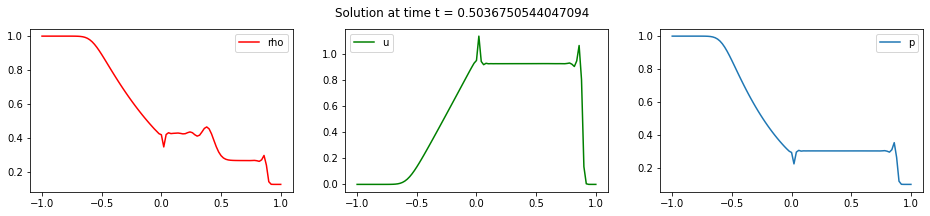

In [12]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

Часть 2


In [16]:
def LaxWendroff(snm1, sn, snp1, tau, h, nu = 0.06):
    po_time = 0.5*(snp1 + sn) - tau/(2*h)*(flux(snp1) - flux(sn))
    po_h = 0.5*(snm1 + sn) - tau/(2*h)*(flux(sn) - flux(snm1))
    ret = sn - tau/h*(flux(po_time)-flux(po_h)) + nu*(snp1 - 2*sn + snm1)
    ret1 = sn - tau/h*(flux(0.5*(snp1 + sn) - tau/(2*h)*(flux(snp1) - flux(sn)))-flux(0.5*(snm1 + sn) - tau/(2*h)*(flux(sn) - flux(snm1)))) + nu*(snp1 - 2*sn + snm1)
    #print(ret)
    return ret1
# Вычисление шага по времени
def get_tau(h, sk, nu = 0.06):
    nx = 101
    rho = np.zeros(nx)
    u  = np.zeros(nx)
    p  = np.zeros(nx)
    
    for i in range(0, nx):
        rho[i], u[i], p[i] = consToPrim(sk[i])

    #podgonka = np.sqrt(gamma * p / rho)

    #max_podgonka = (max(abs(u) + podgonka))
    r = 0.9 # число Куранта
    #tau_k = h/max_podgonka
    return h/(max(abs(u) + np.sqrt(gamma * p / rho)))*np.sqrt(1-2*nu)



tri_d_setka = np.zeros((nx, 3))

po_time = np.array([1,0,1])
po_h = np.array([1/8, 0, 0.1])

tri_d_setka[:int(nx/2) + 1] = primToCons(po_time)
tri_d_setka[int(nx/2) + 1:] = primToCons(po_h)
layer_k_sol = tri_d_setka.copy() # считаем солюшен на слое k

layer_kP1_sol = tri_d_setka.copy() # считаем солюшен на слое k+1

t = 0
taus = []
while t < 0.5:  # шагаем по времени
    layer_k_sol = layer_kP1_sol.copy() # заполняем данными с предыдущего шага
    #tau = 0.001 # здесь постоянный шаг
    tau = get_tau(h, layer_k_sol) # здесь переменный шаг
    taus.append(tau)
    for n in range(1,nx-1): # шагаем по пространству
        
        layer_kP1_sol[n] = LaxWendroff(layer_k_sol[n-1], layer_k_sol[n], layer_k_sol[n+1], tau, h)
    # левое граничное 
    layer_kP1_sol[0] = primToCons(pvl)
    # правое граничное 
    layer_kP1_sol[nx-1] = primToCons(pvr)
    t = t + tau

Text(0.5, 0.98, 'Solution at time t = 0.5012890365234646')

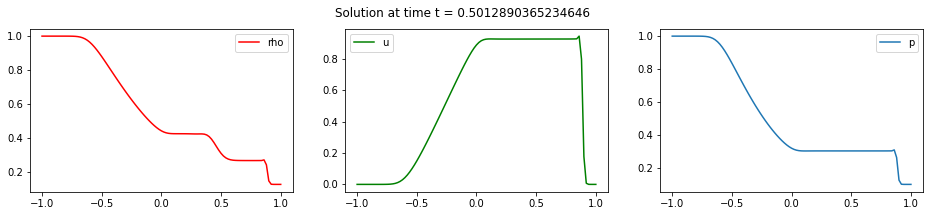

In [20]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in layer_kP1_sol])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

Text(0.5, 0.98, 'Solution at time t = 0.5012890365234646')

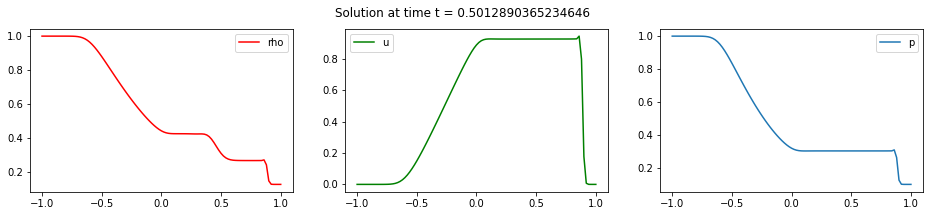

In [21]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in layer_kP1_sol])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

Дано уравнение $\frac{\partial s}{\partial t}+\frac{\partial f(s)}{\partial x}=\frac{\partial}{\partial x}\left(\mu {B}(\mathbf{s}) \frac{\partial s}{\partial x}\right)
$, взятое из книжки. При мю, стремящимся к нулю, система должа приближаться к исходному решению.

 Рассмотрим вязкостный член, с видом $
 h^{2} \frac{\partial^{2} s}{\partial x^{2}} \mu_{a}(t)
$, так как для сохранения второго порядка аппроксимации требуется $\mu= h^{2} \cdot \mu_{a}(t) h^{2} .$

Теже соотношения верны для вязких сил с одним отличием: искусвенная вязкость исчезнет, если h устремить к нулю, а реальная - нет. Аппроксимируем вторую производную в момент $t_k$ и получаем (списываем из книжки) схему Л-В.
$
s_{n}^{k+1}={s}_{n}^{k}-\frac{\tau_{k}}{h}\left({f}_{n+1 / 2}^{k+1 / 2}-{f}_{n-1 / 2}^{k+1 / 2}\right)+{\mu}_{a}^{k} \tau_{k}\left({s}_{n+1}^{k}-2 {s}_{n}^{k}+{s}_{n-1}^{k}\right)
$

Параметр $\nu=\mu_{a}^{k}\cdot \tau_{k}-$ подгоняется под конкретную сетку и задачу. Наша схема требует такое ограничение на шаг по времени: $
\tau_{k} \leqslant \tau_{\max } \sqrt{1-2 \nu}
$ Последнее условие:  матрица ${B}({s})$ должна быть обладает свойством, что решение ${s}(x, t)$ системы было достаточно гладким и при $\mu \rightarrow 0$ приближалось к решению исходной системы. 


В выводе можно сказать, что произошло затухание высокочастотных компонентов решения из-за введения искуственной вязкости и это может быть применено как подавление нефизических оосциляций разностного решения.